# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import jax
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
import imageio
import os

from kernels import *
from sparse_gp import *

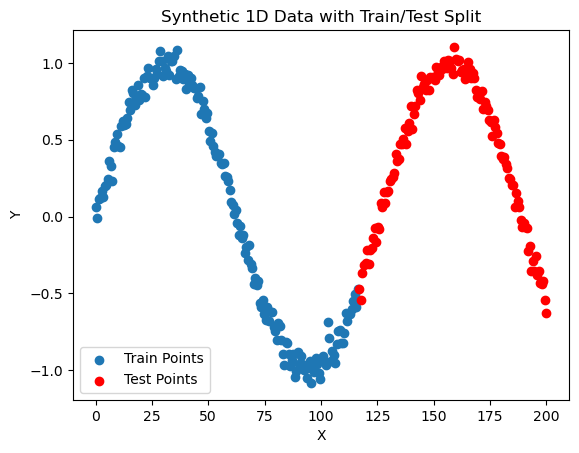

In [2]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Plotting Code
### Resulting Plot

In [3]:
def plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, model_fn):
    # Ensure input arrays are two-dimensional
    X_test = X_test.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)
    Z = Z.reshape(-1, 1)
    numInducing = Z.shape[0]

    # Make predictions on the test set using the optimized hyperparameters
    posterior_mean, posterior_var = model_fn(X_test, X_train, Y_train, Z, optimized_hyperparams)

    # Convert JAX arrays to NumPy arrays for plotting and ensure all are 1D
    posterior_mean = onp.array(posterior_mean).flatten()
    posterior_var = onp.array(posterior_var).flatten()
    X_test = onp.array(X_test).flatten()

    # Ensure all variances are positive
    posterior_var = onp.maximum(posterior_var, 1e-10)

    # Plot the points, predictive mean, and confidence interval
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', label="Training Points")
    plt.scatter(X_test, Y_test, color='red', label="Test Points")

    # Plot predictive mean line and 95% confidence interval
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
    plt.fill_between(X_test,
                     (posterior_mean - 1.96 * onp.sqrt(posterior_var)),
                     (posterior_mean + 1.96 * onp.sqrt(posterior_var)),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.title("Sparse GP Prediction with Uncertainty (Including {numInducing} Inducing Points)")
    plt.show()
#

### Create GIF

In [4]:
# Adjusted function to save individual frames with fixed axis limits and consistent figure size
def save_frame(X_train, Y_train, X_test, Y_test, posterior_mean, posterior_var, step, frame_dir, x_lim, y_lim, title="Sparse GP Optimization"):
    os.makedirs(frame_dir, exist_ok=True)  # Ensure the frame directory exists

    # Set up a fixed figure size to avoid discrepancies
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', label="Training Points")
    plt.scatter(X_test, Y_test, color='red', label="Test Points")
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")

    # Ensure inputs to fill_between are 1-dimensional
    plt.fill_between(X_test.flatten(),
                     (posterior_mean - 1.96 * np.sqrt(posterior_var)).flatten(),
                     (posterior_mean + 1.96 * np.sqrt(posterior_var)).flatten(),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"{title} at Step {step}")

    # Use fixed axis limits for consistent scaling
    plt.xlim(x_lim)
    plt.ylim(y_lim)

    # Position the legend below the plot
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

    # Save frame with tight bounding box to ensure consistent size
    frame_path = os.path.join(frame_dir, f"frame_{step:03d}.png")
    plt.savefig(frame_path, bbox_inches="tight")
    plt.close()
#

def generate_frames(X_train, Y_train, X_test, Y_test, Z, history, frame_dir="frames", title=None):
    os.makedirs(frame_dir, exist_ok=True)  # Ensure the frame directory exists

    # Determine fixed axis limits based on overall data range
    x_min, x_max = min(X_train.min(), X_test.min()), max(X_train.max(), X_test.max())
    y_min, y_max = -3 + min(Y_train.min(), Y_test.min()), 3 + max(Y_train.max(), Y_test.max())
    x_lim, y_lim = (x_min, x_max), (y_min, y_max)
    
    for entry in history:
        step = entry["step"]
        hyperparams = entry["hyperparams"]

        # Compute posterior predictions
        posterior_mean, posterior_var = sparse_gp_posterior_predictive(X_test, X_train, Y_train, Z, hyperparams)

        # Convert JAX arrays to NumPy for plotting
        posterior_mean = onp.array(posterior_mean).flatten()
        posterior_var = onp.array(posterior_var).flatten()

        # Save the current frame with fixed axis limits
        save_frame(X_train, Y_train, X_test, Y_test, posterior_mean, posterior_var, step, frame_dir, x_lim, y_lim, title)
    #
#

def check_frame_shapes(frame_dir):
    frame_paths = sorted([os.path.join(frame_dir, fname) for fname in os.listdir(frame_dir) if fname.endswith(".png")])
    shapes = set()

    for frame_path in frame_paths:
        img = imageio.imread(frame_path)
        shapes.add(img.shape)
    #

    if len(shapes) > 1:
        raise ValueError("Not all frames have the same shape. Check the frame generation for consistency.")
    else:
        print("All frames have consistent shape.")
    #
#

def create_gif(frame_dir="frames", gif_filename="sparse_gp_optimization.gif"):
    frames = []
    frame_paths = sorted([os.path.join(frame_dir, fname) for fname in os.listdir(frame_dir) if fname.endswith(".png")])

    # Load frames and handle the case where no frames are found
    if not frame_paths:
        print(f"No frames found in {frame_dir}. Check the frame directory path and ensure frames were saved.")
        return
    #

    # Check for consistent shapes before saving GIF
    check_frame_shapes(frame_dir)

    for frame_path in frame_paths:
        frames.append(imageio.imread(frame_path))
    #
    
    gif_path = os.path.join(frame_dir, gif_filename) 
    imageio.mimsave(gif_path, frames, fps=2)
    print(f"GIF saved to {gif_path}")
#

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [5]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Assuming two kernels, with unconstrained weights and initial values for each kernel's hyperparams
    initial_weights = [onp.log(0.5), onp.log(0.5)]  # log-space for unconstrained initial weights
    hyperparams_sqexp = [0.1, 1.0, 10.0]  # Initial values for noise, signal, length_scale for sq-exp kernel
    hyperparams_linear = [0.1, 1.0]  # Initial values for noise, signal for linear kernel
    
    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear
    return np.array(initial_params)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [6]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -161.71841459344606
Step 10, ELBO: -154.95190110324592
Step 20, ELBO: -99.32418376846383
Step 30, ELBO: 5.02537958214711
Step 40, ELBO: 7.355202035667503
Step 50, ELBO: 7.364108014935226
Step 60, ELBO: 7.368691783191451
Step 70, ELBO: 7.372899232557046
Step 80, ELBO: 7.377060870172073
Step 90, ELBO: 7.381210177908258
Step 100, ELBO: 7.385351332312865
Step 110, ELBO: 7.389485439089384
Step 120, ELBO: 7.3936132402799615
Step 130, ELBO: 7.397735395848429
Step 140, ELBO: 7.401852522584051
Step 150, ELBO: 7.405965192475122
Step 160, ELBO: 7.410073941919649
Step 170, ELBO: 7.414179269335392
Step 180, ELBO: 7.418281639565549
Step 190, ELBO: 7.422381485018718
Optimized Hyperparameters: [9.93995637e-01 6.00436349e-03 1.10517092e+00 4.28461208e+00
 4.13087527e+03 1.03492979e+00 2.12552435e+00]
Final ELBO Value: 7.4260695213982615


In [7]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [9.93995637e-01 6.00436349e-03 1.10517092e+00 4.28461208e+00
 4.13087527e+03 1.03492979e+00 2.12552435e+00]
sum of First 2 Weights: 1.0


## Predict and Plot the Results

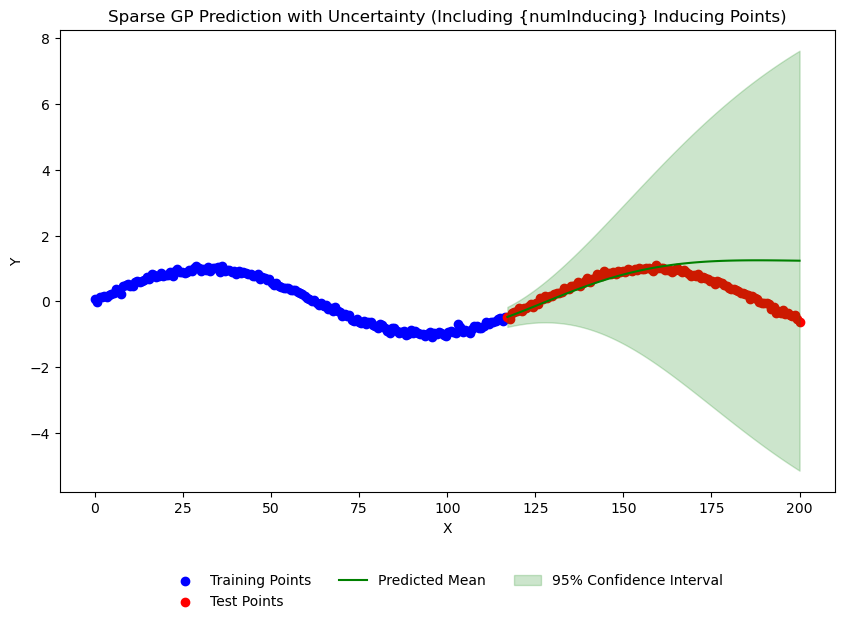

In [8]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [9]:
# Extract weights from optimized hyperparameters (assuming the first two entries are the weights)
weights = optimized_hyperparams[:2]

# Convert weights to percentages
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[2]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[6]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 99.40%
Kernel 2 (Linear): 0.60%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1.1052
Kernel 1 - Signal Variance: 4.2846
Kernel 1 - Length Scale: 4130.8753
Kernel 2 - Noise Variance: 1.0349
Kernel 2 - Signal Variance: 2.1255


In [10]:
# Ensure input arrays are two-dimensional
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
Z = Z.reshape(-1, 1)

# Generate frames, specifying a custom directory
generate_frames(X_train, Y_train, X_test, Y_test, Z, history, frame_dir="frames/simple2d_sqexp_linear_20inducing", title="Sparse GP Optimization (20 Inducing Points)")

# Create the GIF, specifying the output directory and filename
create_gif(frame_dir="frames/simple2d_sqexp_linear_20inducing", gif_filename="optimization_simple2d_sqexp_linear_20inducing.gif")

/var/folders/59/c_yt8mfs3llggf7zh1pnsj900000gn/T/ipykernel_62405/1561067742.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(frame_path)
/var/folders/59/c_yt8mfs3llggf7zh1pnsj900000gn/T/ipykernel_62405/1561067742.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


All frames have consistent shape.
GIF saved to frames/simple2d_sqexp_linear_20inducing/optimization_simple2d_sqexp_linear_20inducing.gif


# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [11]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Assuming two kernels, with unconstrained weights and initial values for each kernel's hyperparams
    initial_weights = [onp.log(0.5), onp.log(0.5)]  # log-space for unconstrained initial weights
    hyperparams_sqexp = [0.1, 1.0, 10.0]  # Initial values for noise, signal, length_scale for sq-exp kernel
    hyperparams_linear = [0.1, 1.0]  # Initial values for noise, signal for linear kernel
    
    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear
    return np.array(initial_params)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [12]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -161.71841459344606
Step 10, ELBO: -154.95190110324592
Step 20, ELBO: -99.32418376846383
Step 30, ELBO: 5.02537958214711
Step 40, ELBO: 7.355202035667503
Step 50, ELBO: 7.364108014935226
Step 60, ELBO: 7.368691783191451
Step 70, ELBO: 7.372899232557046
Step 80, ELBO: 7.377060870172073
Step 90, ELBO: 7.381210177908258
Step 100, ELBO: 7.385351332312865
Step 110, ELBO: 7.389485439089384
Step 120, ELBO: 7.3936132402799615
Step 130, ELBO: 7.397735395848429
Step 140, ELBO: 7.401852522584051
Step 150, ELBO: 7.405965192475122
Step 160, ELBO: 7.410073941919649
Step 170, ELBO: 7.414179269335392
Step 180, ELBO: 7.418281639565549
Step 190, ELBO: 7.422381485018718
Optimized Hyperparameters: [9.93995637e-01 6.00436349e-03 1.10517092e+00 4.28461208e+00
 4.13087527e+03 1.03492979e+00 2.12552435e+00]
Final ELBO Value: 7.4260695213982615


In [13]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [9.93995637e-01 6.00436349e-03 1.10517092e+00 4.28461208e+00
 4.13087527e+03 1.03492979e+00 2.12552435e+00]
sum of First 2 Weights: 1.0


## Predict and Plot the Results

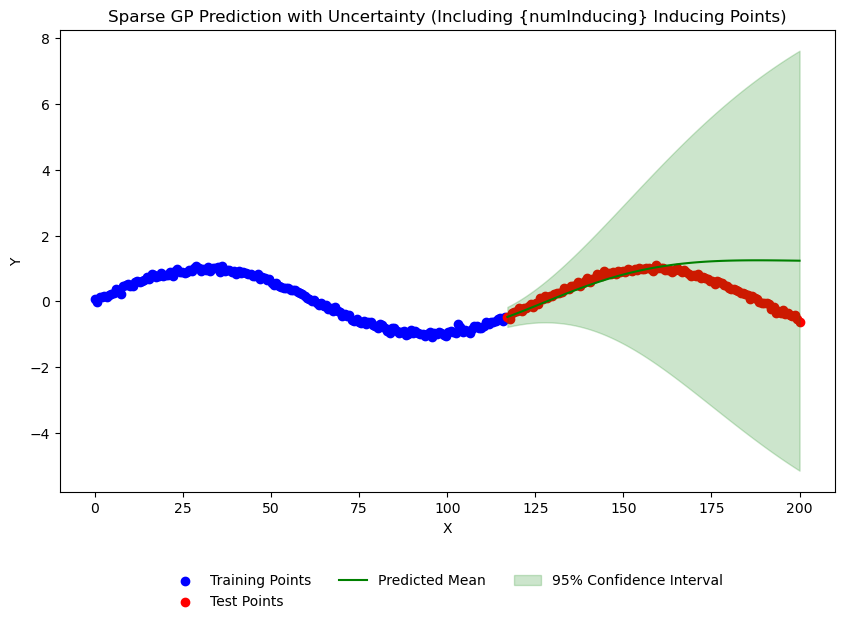

In [14]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [15]:
# Extract weights from optimized hyperparameters (assuming the first two entries are the weights)
weights = optimized_hyperparams[:2]

# Convert weights to percentages
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[2]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[6]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 99.40%
Kernel 2 (Linear): 0.60%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1.1052
Kernel 1 - Signal Variance: 4.2846
Kernel 1 - Length Scale: 4130.8753
Kernel 2 - Noise Variance: 1.0349
Kernel 2 - Signal Variance: 2.1255


In [16]:
# Ensure input arrays are two-dimensional
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)
Z = Z.reshape(-1, 1)

# Generate frames, specifying a custom directory
generate_frames(X_train, Y_train, X_test, Y_test, Z, history, frame_dir="frames/simple2d_sqexp_linear_50inducing", title="Sparse GP Optimization (50 Inducing Points)")

# Create the GIF, specifying the output directory and filename
create_gif(frame_dir="frames/simple2d_sqexp_linear_50inducing", gif_filename="optimization_simple2d_sqexp_linear_50inducing.gif")

/var/folders/59/c_yt8mfs3llggf7zh1pnsj900000gn/T/ipykernel_62405/1561067742.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(frame_path)
/var/folders/59/c_yt8mfs3llggf7zh1pnsj900000gn/T/ipykernel_62405/1561067742.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


All frames have consistent shape.
GIF saved to frames/simple2d_sqexp_linear_50inducing/optimization_simple2d_sqexp_linear_50inducing.gif
